✅ Dataset Loaded Successfully
Shape: (14000, 27)
   Age     BusinessTravel  DailyRate              Department  \
0   21  Travel_Frequently        478  Research & Development   
1   50         Non-Travel        908  Research & Development   
2   45      Travel_Rarely       1448         Human Resources   
3   36         Non-Travel       1095         Human Resources   
4   36  Travel_Frequently        535         Human Resources   

   DistanceFromHome  Education  EnvironmentSatisfaction  Gender  JobLevel  \
0                 2          4                        1  Female         4   
1                19          1                        1    Male         1   
2                18          2                        1    Male         1   
3                25          1                        2    Male         5   
4                17          2                        1  Female         1   

                     JobRole  ...  RelationshipSatisfaction StockOptionLevel  \
0     Manufacturing Dir

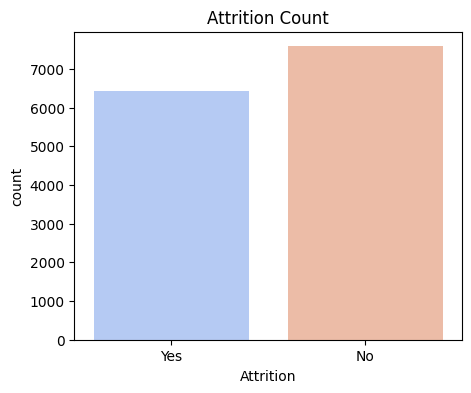

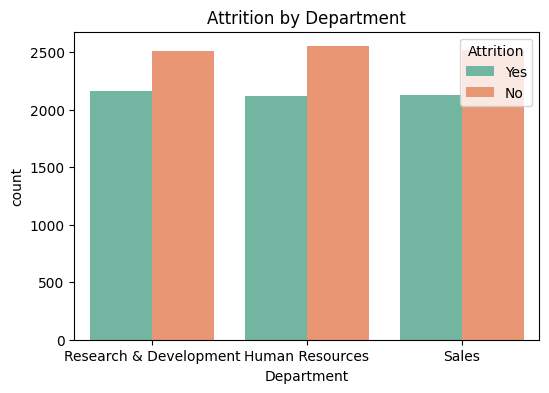

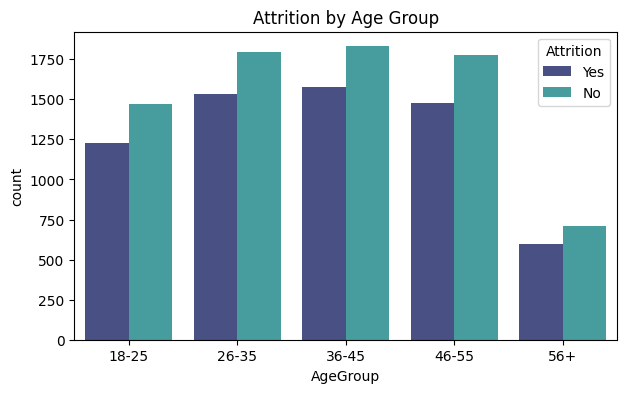

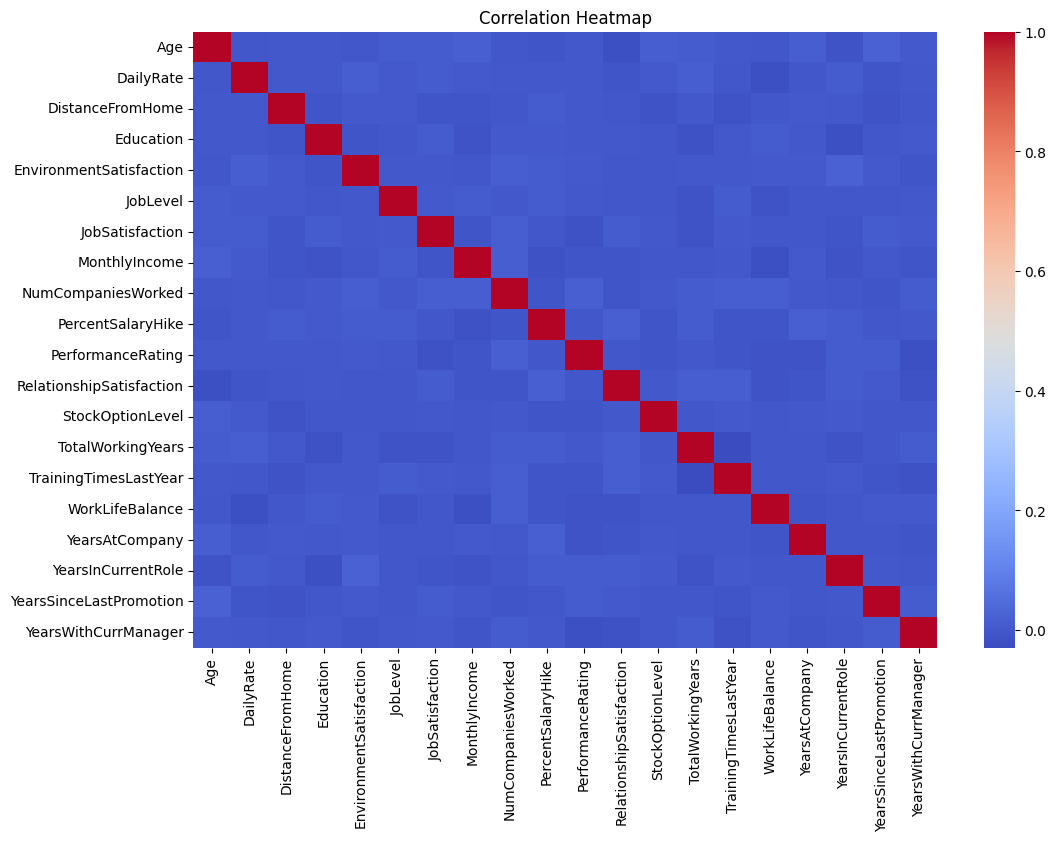


Class Distribution:
Attrition_flag
0    0.541607
1    0.458393
Name: proportion, dtype: float64

Model Accuracy Comparison:
Logistic Regression: 81.86%
Decision Tree: 78.61%
Random Forest: 83.54%
Gradient Boosting: 83.61%
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}

🎉 PKL FILE GENERATED SUCCESSFULLY:
👉 /content/attrition_model_pipeline.pkl

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1517
           1       0.81      0.85      0.83      1283

    accuracy                           0.84      2800
   macro avg       0.84      0.84      0.84      2800
weighted avg       0.84      0.84      0.84      2800

Accuracy: 0.8378571428571429
ROC-AUC: 0.9297583993513883

✅ Training Complete!


In [7]:
# ========================================
# EMPLOYEE ATTRITION PREDICTION PROJECT (Optimized for Synthetic Dataset)
# ========================================

# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings("ignore")

try:
    import shap
    _HAS_SHAP = True
except ImportError:
    _HAS_SHAP = False

RANDOM_STATE = 42
SAVE_PATH = "/content/attrition_model_pipeline.pkl"   # <<==== PKL FILE OUTPUT

# ========================================
# 1️⃣ LOAD DATASET
# ========================================
df = pd.read_csv("/content/Synthetic_HR_Attrition_14000.csv")
print("✅ Dataset Loaded Successfully")
print("Shape:", df.shape)
print(df.head())

expected_cats = [
    'BusinessTravel', 'Department', 'Gender', 'JobRole',
    'MaritalStatus', 'OverTime', 'Attrition'
]
for c in expected_cats:
    if c in df.columns:
        df[c] = df[c].astype(str)

# ========================================
# 2️⃣ CHECK FOR MISSING VALUES & CLEANING
# ========================================
print("\nMissing Values per column:")
print(df.isnull().sum())

print("\nDataset info:")
print(df.info())

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for nc in num_cols:
    if df[nc].isnull().any():
        df[nc].fillna(df[nc].median(), inplace=True)

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for cc in cat_cols:
    if df[cc].isnull().any():
        df[cc].fillna("Missing", inplace=True)

# ========================================
# 3️⃣ EDA
# ========================================
plt.figure(figsize=(5,4))
sns.countplot(x='Attrition', data=df, palette='coolwarm')
plt.title("Attrition Count")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='Department', hue='Attrition', data=df, palette='Set2')
plt.title("Attrition by Department")
plt.show()

df['Age'] = df['Age'].clip(18, 65)
df['AgeGroup'] = pd.cut(df['Age'], [17,25,35,45,55,65],
                        labels=['18-25','26-35','36-45','46-55','56+'])
plt.figure(figsize=(7,4))
sns.countplot(x='AgeGroup', hue='Attrition', data=df, palette='mako')
plt.title("Attrition by Age Group")
plt.show()

plt.figure(figsize=(12,8))
corr = df.select_dtypes(include=['int64','float64']).corr()
sns.heatmap(corr, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# ========================================
# 4️⃣ FEATURE ENGINEERING
# ========================================
drop_cols = ['EmployeeCount','StandardHours','Over18','EmployeeNumber','AgeGroup']
for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

df['YearsAtCompany_by_Age'] = df['YearsAtCompany'] / (df['Age'] + 1)
df['YearsSinceLastPromotion_flag'] = (df['YearsSinceLastPromotion'] > 0).astype(int)

df['Attrition_flag'] = df['Attrition'].map({'Yes':1, 'No':0})

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [c for c in categorical_cols if c != 'Attrition']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df = df.loc[:, ~df.columns.duplicated()]

X = df.drop(['Attrition', 'Attrition_flag'], axis=1, errors='ignore')
y = df['Attrition_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("\nClass Distribution:")
print(y_train.value_counts(normalize=True))

# ========================================
# 5️⃣ SMOTE + SCALING
# ========================================
smote = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ========================================
# 6️⃣ MODEL COMPARISON
# ========================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

print("\nModel Accuracy Comparison:")
for name, mdl in models.items():
    mdl.fit(X_train_scaled, y_train_res)
    acc = accuracy_score(y_test, mdl.predict(X_test_scaled))
    print(f"{name}: {acc*100:.2f}%")

# ========================================
# 7️⃣ HYPERPARAMETER TUNING (RandomForest)
# ========================================
param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 6, 12, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

search.fit(X_train_scaled, y_train_res)

best_model = search.best_estimator_
print("\nBest Parameters:", search.best_params_)

# ========================================
# 8️⃣ SAVE MODEL AS .PKL
# ========================================
artifact = {
    "model": best_model,
    "scaler": scaler,
    "columns": X.columns.tolist()
}

with open(SAVE_PATH, "wb") as file:
    joblib.dump(artifact, file)

print(f"\n🎉 PKL FILE GENERATED SUCCESSFULLY:\n👉 {SAVE_PATH}")

# ========================================
# 9️⃣ EVALUATION
# ========================================
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:,1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# ========================================
# 🔟 END
# ========================================
print("\n✅ Training Complete!")
